### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [2]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


In [3]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 6))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

Familiarization
There are multiple signal types visible in the training data. The first signal type shows, high signal strength (between 500 and 1000), cyclic behaviour and has a high variance, a good example is FIT201. The second type is one that shows very low signal strength(between 0 and 1), and low variance, A good example would be P402. the third type is medium signal strength (between 300 and 400), a good example would be AIT203.

Some of the signals seem to be correlated. LIT401 and LIT101 show some negative correlation in the sense that LIT101 increases while LIT401 decreases. This is also a form of cyclic behaviour as LIT401 constantly decreases and increases while LIT101 constantly increases and then decreases.

In [4]:
def visualize_sensor_data_points(data, window, sensors, ax):
    start, end = window
    subset = data[sensors][start:end]
    for sensor in sensors:
        ax.plot(subset.index, subset[sensor], label=sensor)
    ax.set_title(f"Data from {start} to {end}")
    ax.set_xlabel("Data Point")
    ax.set_ylabel("Sensor Reading")
    ax.legend()
    ax.grid(True)

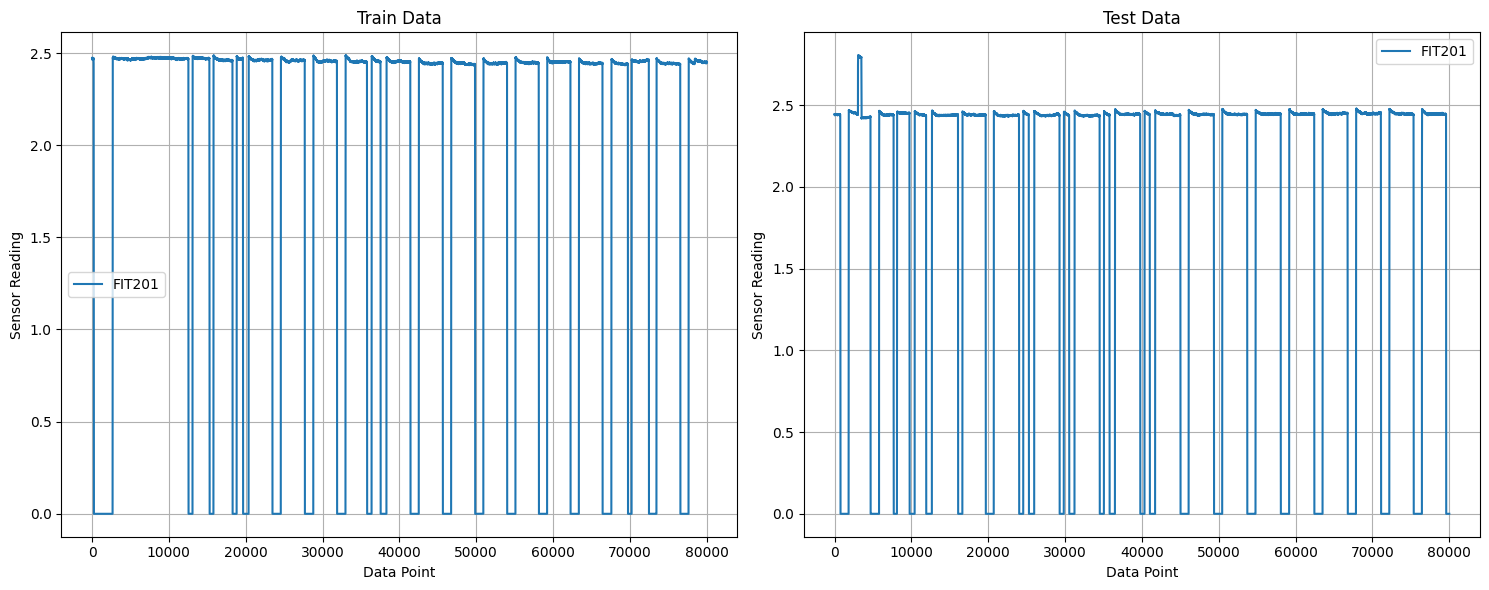

In [5]:
#cyclic behaviour
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

visualize_sensor_data_points(train_data, window=(0, 80000), sensors=['FIT201'], ax=axes[0])
axes[0].set_title("Train Data")

visualize_sensor_data_points(test_data, window=(0, 80000), sensors=['FIT201'], ax=axes[1])
axes[1].set_title("Test Data")

plt.tight_layout()
plt.show()

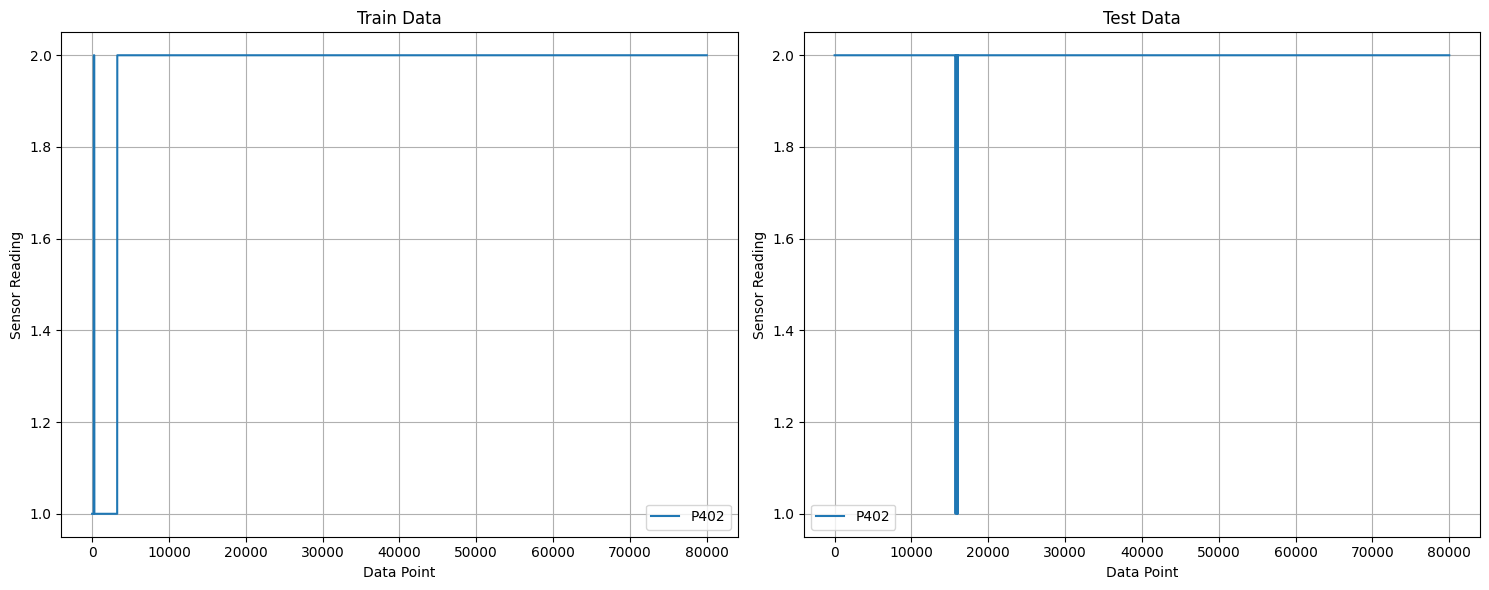

In [6]:
#very low signal strength
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

visualize_sensor_data_points(train_data, window=(0, 80000), sensors=['P402'], ax=axes[0])
axes[0].set_title("Train Data")

visualize_sensor_data_points(test_data, window=(0, 80000), sensors=['P402'], ax=axes[1])
axes[1].set_title("Test Data")

plt.tight_layout()
plt.show()

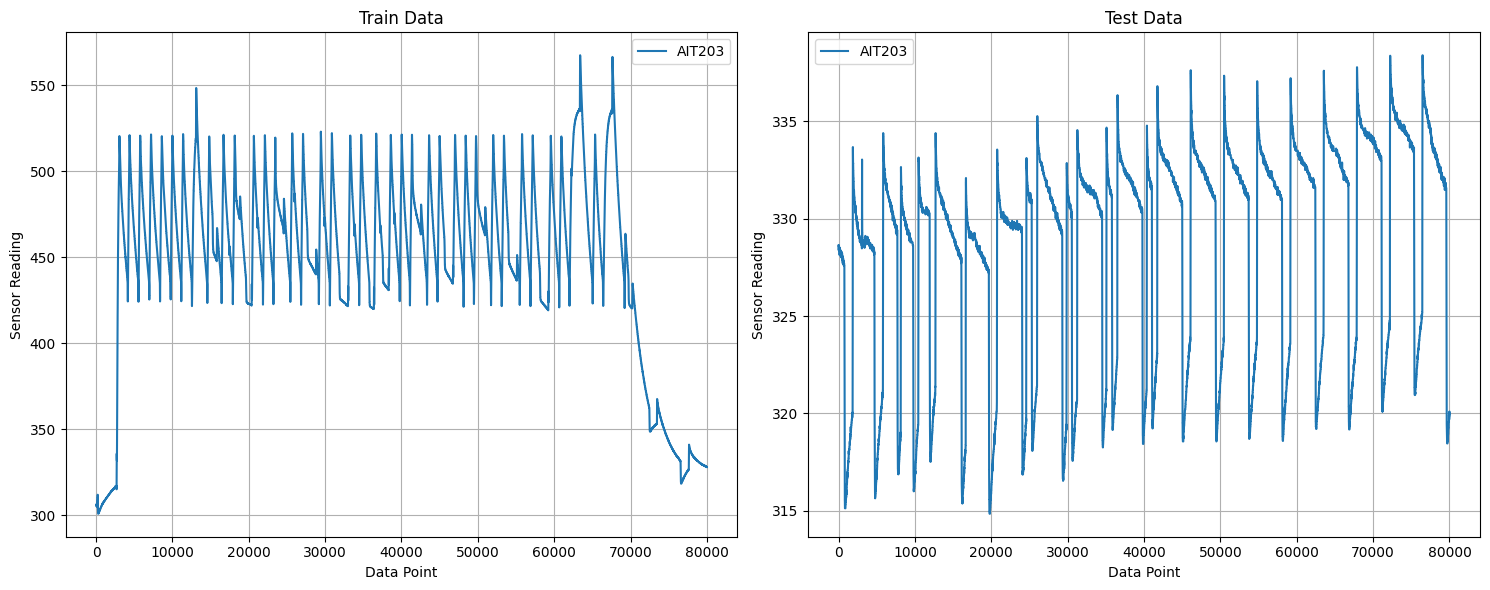

In [7]:
#medium signal strength
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

visualize_sensor_data_points(train_data, window=(0, 80000), sensors=['AIT203'], ax=axes[0])
axes[0].set_title("Train Data")

visualize_sensor_data_points(test_data, window=(0, 80000), sensors=['AIT203'], ax=axes[1])
axes[1].set_title("Test Data")

plt.tight_layout()
plt.show()

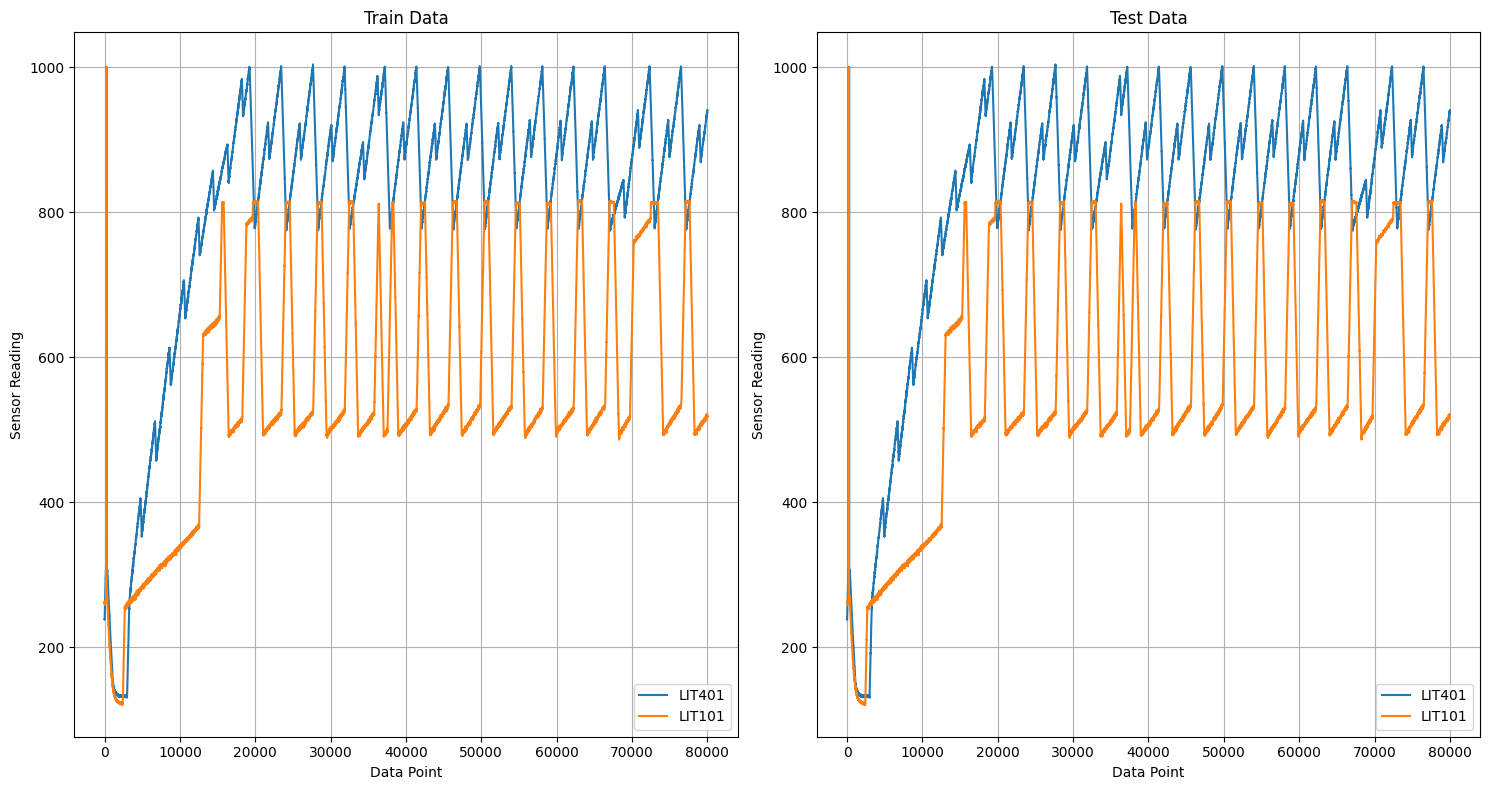

In [8]:
#correlation
fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# Plot training data on the first subplot
visualize_sensor_data_points(train_data, window=(0, 80000), sensors=['LIT401', 'LIT101'], ax=axes[0])
axes[0].set_title("Train Data")

# Plot test data on the second subplot
visualize_sensor_data_points(train_data, window=(0, 80000), sensors=['LIT401', 'LIT101'], ax=axes[1])
axes[1].set_title("Test Data")

plt.tight_layout()
plt.show()


### Dynamic time warping implementation. 
The dynamic_time_warping implementation creates a matrix that is 1 bigger than the two signals that are being compared in both the x and y axis. The matrix is filled with the euclidean distance between the two signals at each point. the matrix is then filled with the cost of the currently compared data point plus the minimum of the costs in [DTW[i-1, j ], DTW[i , j-1],DTW[i-1, j-1]]. The last point in the matrix is the distance between the two signals. The distance between the two signals is then returned.

In terms of the types of anomolies we expect to find, it depends on the window size we choose for sliding windows. If we choose a small window size, we will find contextual anomolies, while if we choose a large window size, we will find collective anomolies.

In [9]:
def dynamic_time_warping(a, b):

    n = a.size
    m = b.size
    DTW = np.zeros(shape=(n +1 , m+1))

    for i in range(0, n+1):
        for j in range(0, m+1):
            DTW[i, j] = np.inf
    DTW[0,0] = 0

    for i in range(1, n +1):
        for j in range(1, m+1):
            cost = (a[i -1] - b[j-1])**2
            DTW[i, j] = cost + np.min([DTW[i-1, j ],    
                                        DTW[i  , j-1],   
                                        DTW[i-1, j-1]])  
    i = n
    j = m
    dist = DTW[i,j]
    return np.sqrt(dist)

Two functions to visualize the data



In [10]:
def visualize_sensor_data(df, window=None, sensors=None, skip =1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    #print(len(df))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index].iloc[::skip], df[sensor][start_index:end_index].iloc[::skip], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()
def visualize_sensor_data2(data, window, sensors, ax):
    start, end = window
    subset = data[sensors][start:end]
    for sensor in sensors:
        ax.plot(subset.index, subset[sensor], label=sensor)
    ax.set_title(f"Data from {start} to {end}")
    ax.set_xlabel("Data Point")
    ax.set_ylabel("Sensor Reading")
    ax.legend()
    ax.grid(True)


Function to visualize the distance (residual)

In [11]:
def compute_residuals(df, window=None, sensors=None, sliding_window_size = 0, treshold = 0, jump_size = 0, frac = 1, skip = 1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    
   # df_subsampled = df.sample(frac=frac, random_state=42)
    
    # Plot each sensor in a different color
    #plt.figure(figsize=(15, 8))
    for sensor in sensors:
        #plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)
        distances = []
        anomolies = []
        sliding_windows = np.lib.stride_tricks.sliding_window_view(df[sensor][start_index:end_index].iloc[::skip], sliding_window_size)
        for i in range(len(sliding_windows) - sliding_window_size):
            distance = dynamic_time_warping(sliding_windows[start_index + i], sliding_windows[start_index +i+sliding_window_size])
            distances.append(distance)
            if (distance >= treshold):
                anomolies.append(distance)
            #increase i by jump size, also known as stride
            i += jump_size
            
        return distances

Here we visualize the distances (residuals). To improve performance we've decided to sample the data by taking every 1000th data point as which is what the "skip" variable is for. taking this as our sample still maintains the overall shape of the original graph. through the residual graph we can detect the anamoly as it shows a very high peak around that time, for this reason we set our treshhold to 30 to detect the anamoly. The first two graphs are the sensor data and residuals for the training data, while the last two are the sensor data and residuals for the test data.

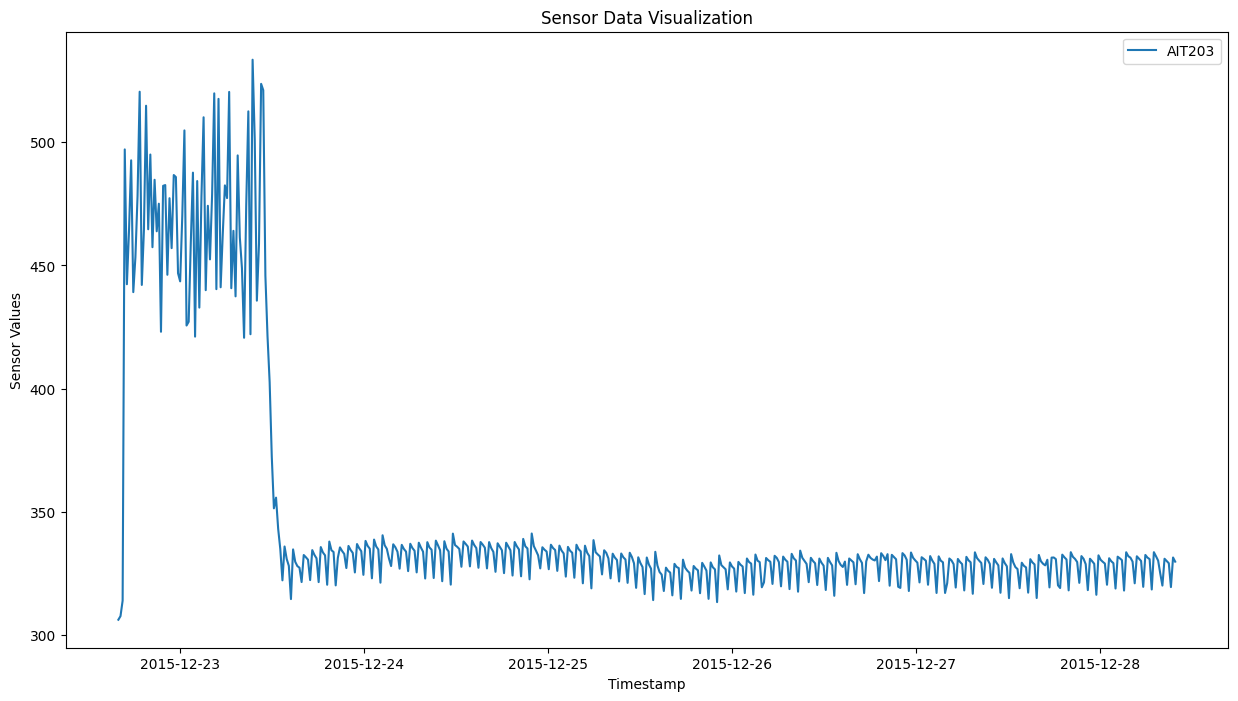

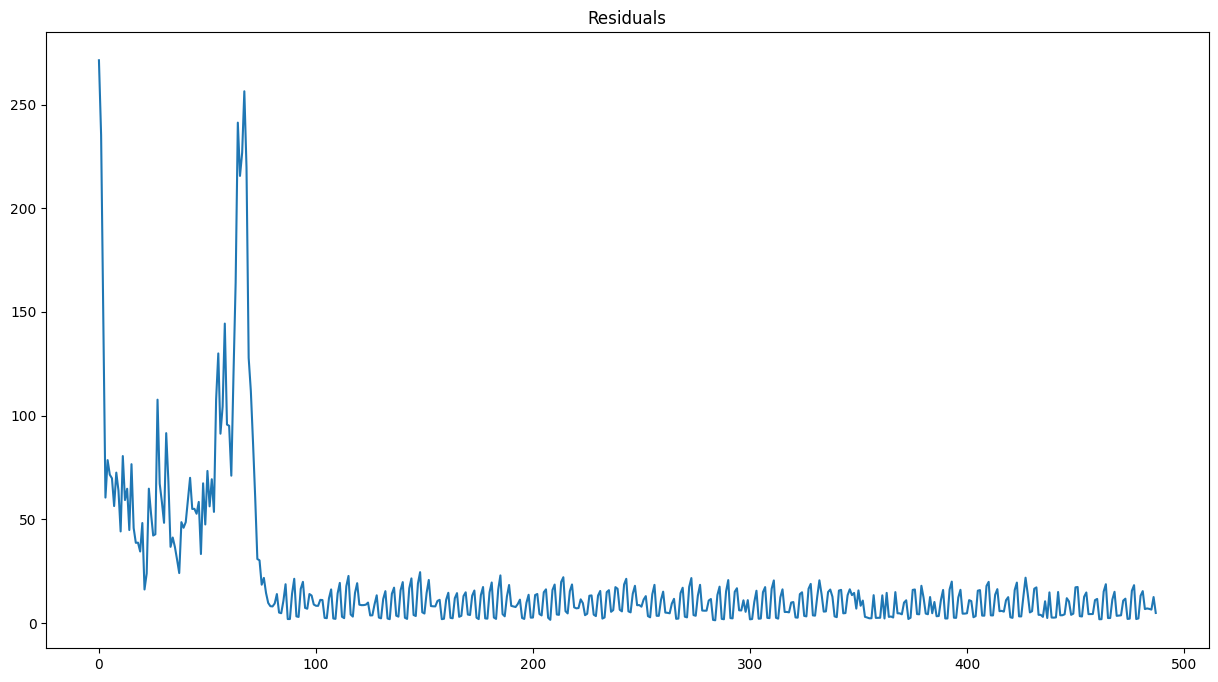

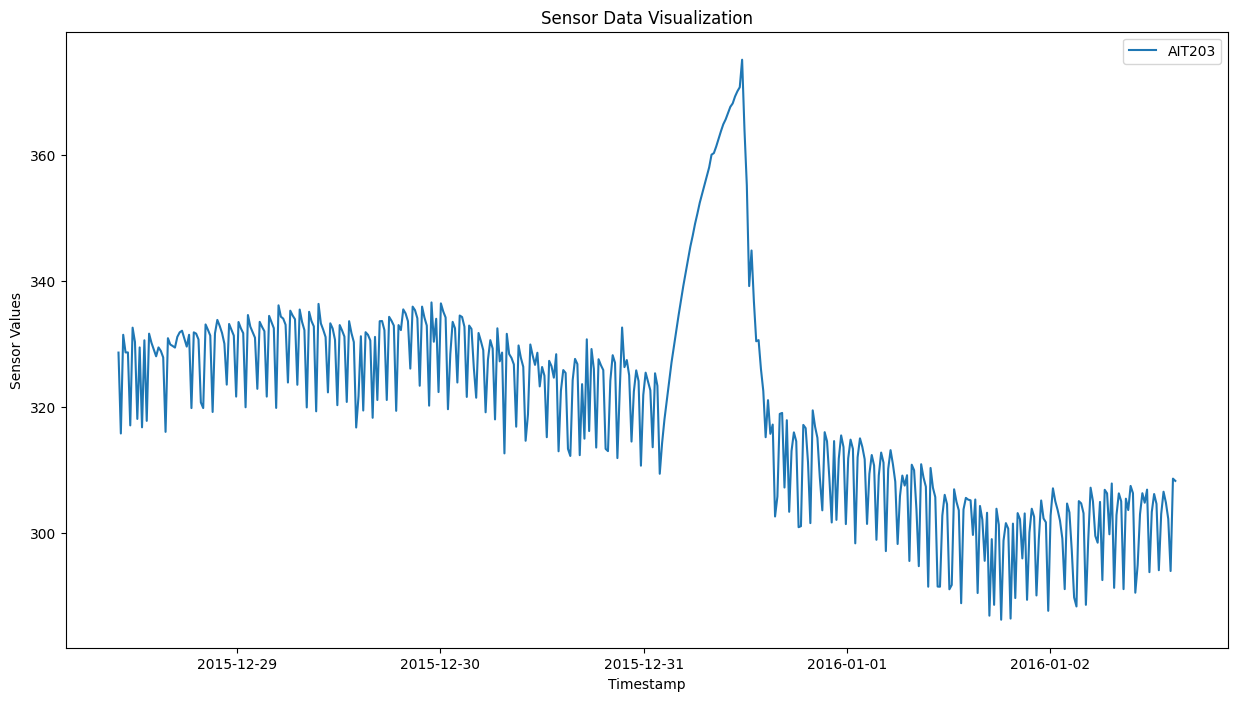

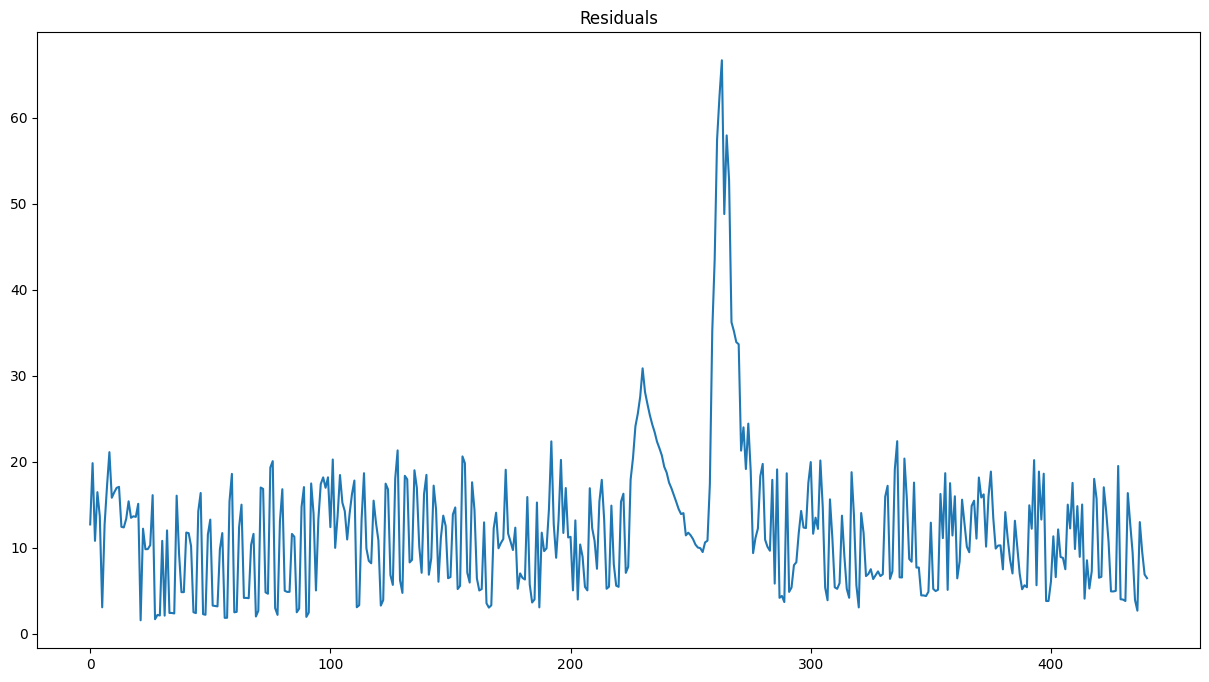

In [12]:
def visualize_distance(df,timestamps =None, window=None, sensors=None, sliding_window_size = 0, treshold = 0, jump_size = 0, skip = 1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    
    residuals = compute_residuals(df.iloc[::skip], window, sensors, sliding_window_size, treshold, jump_size, skip)
    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    plt.title('Residuals')
    plt.plot( residuals)  

    plt.show() 

    

       
#visualize_sensor_data(train_data)
#visualize_sensor_data(test_data)


visualize_sensor_data(train_data, window=(0, 500000), sensors=['AIT203'], skip=1000)
visualize_distance(train_data, window=(0, 500000),  sensors=['AIT203'], sliding_window_size =5, jump_size=0, skip = 1000)
visualize_sensor_data(test_data, window=(0, 500000), sensors=['AIT203'], skip=1000)
visualize_distance(test_data, window=(0, 500000),  sensors=['AIT203'], sliding_window_size =5, jump_size=0, skip = 1000)

### PCA implementation

The principal_component_analysis implementation first computes the covariance matrix of the data, then it does the eigen decomposition to obtain the eigenvalues and eigenvectors. Lastly we sort the values and select the top k eigenvectors.
The apply_principal_component_analysis centers the data, and then it projects it using the eigenvectors calculated before, and lastly we reduce the dimensionality of the data to the number of principal components.

In [13]:
def principal_component_analysis(df, k):
    cov_mat = np.cov(df, rowvar = False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
    sIndex = np.argsort(eigenvalues)[::-1]
    sEigenvectors = eigenvectors[:, sIndex]
    sEigenvectors = sEigenvectors[:, 0:k]

    return sEigenvectors


def apply_principal_component_analysis(df, eigenvectors):
    centered_data = df - df.mean(axis=0)
    projected_data = np.dot(centered_data, eigenvectors)
    return pd.DataFrame(projected_data)

### PCA Pipeline

1. Preprocessing data

For pre-processing the data we normalize the data sets by centering them to the mean. This is necessary because PCA is sensitive to the scale of the features in the data and without normalization feature with larger scale can dominate the principal components. Moreover, this helps to ensure that each feature contributes equally to the variance calculation.

In [20]:
def normalize_data(df):
    return (df - df.mean())

sensor_columns_train = train_data.columns[1:-1]
sensor_columns_test = test_data.columns[1:-1]

normalized_train_data = normalize_data(train_data[sensor_columns_train])
normalized_test_data = normalize_data(test_data[sensor_columns_test])

2. Train PCA on the Train Data and apply it on the test and the train data set

When selecting a number of principal components that is way too small such as 3 we can see on the train data that even the average residual varies quite a lot between 0 and 100, and we can also observe abnormalities where it goes all the way up to 200 a couple of times and even to around 450 and in the test data this results in having alot  residuals twice the usual size. If we select a number of components that is way too high such as 30 we can see the residuals value significantly decrease, but we can also immediately see on the test data a lot of outliers. If we pick a good number of principal components such as 19 we see that the residual value is similarly low for both the test and the train data and in the test data we only see two very large outliers. 19 being a good choice for principal components can also be observed in the cells lower down where we plot the residual from k = 15 to k = 21 where it becomes obvious how the anomaly detection improves significantly  at every step from 15 to 19 and how it sops significantly improving after that.
We do not see many very large abnormalities in the training data, but one that we do see quite clearly is the one that can be observed at the very beginning of the plot. This occurs because the point where the abnormality is located at significantly deviates from the predominant pattern captured by the principal components.
With the use of PCA we can expect to detect the data points that do not conform to patterns in the data, we can also identify correlations in the data, and we can reduce redundant features.

In [21]:
k = 19
eigenvectors = principal_component_analysis(normalized_train_data, k)

# Transform both train and test data
transformed_train_data = apply_principal_component_analysis(normalized_train_data, eigenvectors)
transformed_test_data = apply_principal_component_analysis(normalized_test_data, eigenvectors)

3. Compute Residual

In the calculate_residuals function we first reconstruct the original data from the one that was transformed with PCA and then we calculate the Euclidean distance between the original data points and their reconstructed versions after PCA transformation.

In [22]:
def calculate_residuals(original_data, transformed_data, eigenvectors, original_mean):
    if isinstance(original_mean, pd.Series):
        original_mean = original_mean.values
    reconstructed_data = np.dot(transformed_data, eigenvectors.T) + original_mean
    residuals = np.linalg.norm(original_data - reconstructed_data, axis=1)
    return residuals

original_mean_train = normalized_train_data.mean(axis=0).values
original_mean_test = normalized_test_data.mean(axis=0).values

residuals_train = calculate_residuals(normalized_train_data.values, transformed_train_data, eigenvectors, original_mean_train)
residuals_test = calculate_residuals(normalized_test_data.values, transformed_test_data, eigenvectors, original_mean_test)


In [23]:
def visualize_pca_residuals(residuals, timestamps, title='PCA Residuals'):
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, residuals, color='blue')
    plt.xlabel('Timestamp')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.grid(True)
    plt.show()

We plot the residuals for the test and the train data with our selected number of principal components (k = 19),

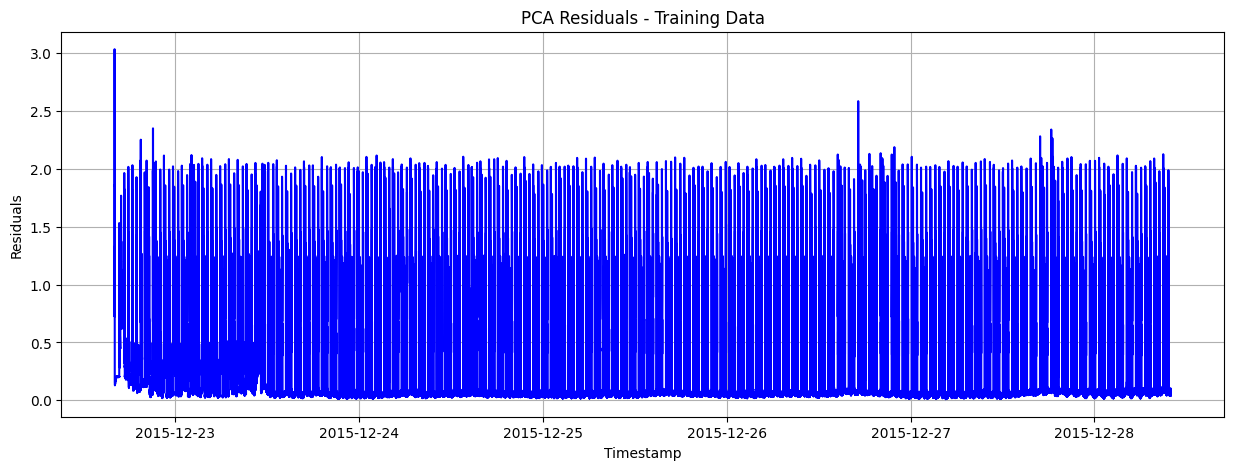

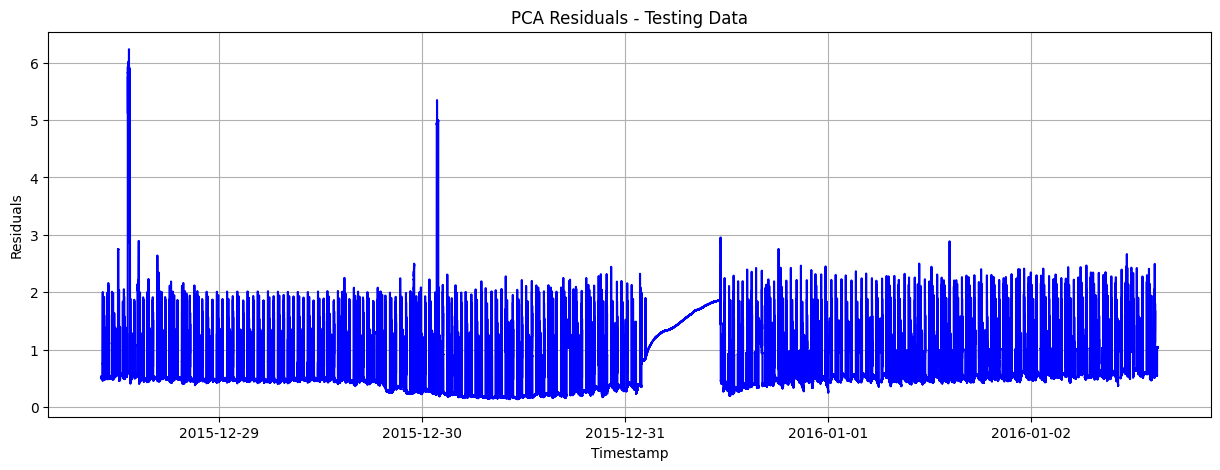

In [24]:
visualize_pca_residuals(residuals_train, train_data['Timestamp'][0:len(residuals_train)], 'PCA Residuals - Training Data')

# Visualize PCA residuals for the testing data
visualize_pca_residuals(residuals_test, test_data['Timestamp'][0:len(residuals_test)], 'PCA Residuals - Testing Data')

Here we apply PCA multiple times with the number of principal components in the range 15 to 23. This helped us choose the correct value for k. We can observe how from 15 to 19 the number of abnormalities reduces. We can also see that from 19 to 20 there is no significant difference which is why we select the value 19 for our number of principal components.

In [25]:
train_file_path = 'lab1_train.csv'

train_data_original = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data_original['Timestamp'] = pd.to_datetime(train_data_original['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data_original = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
test_data_original['Timestamp'] = pd.to_datetime(test_data_original['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

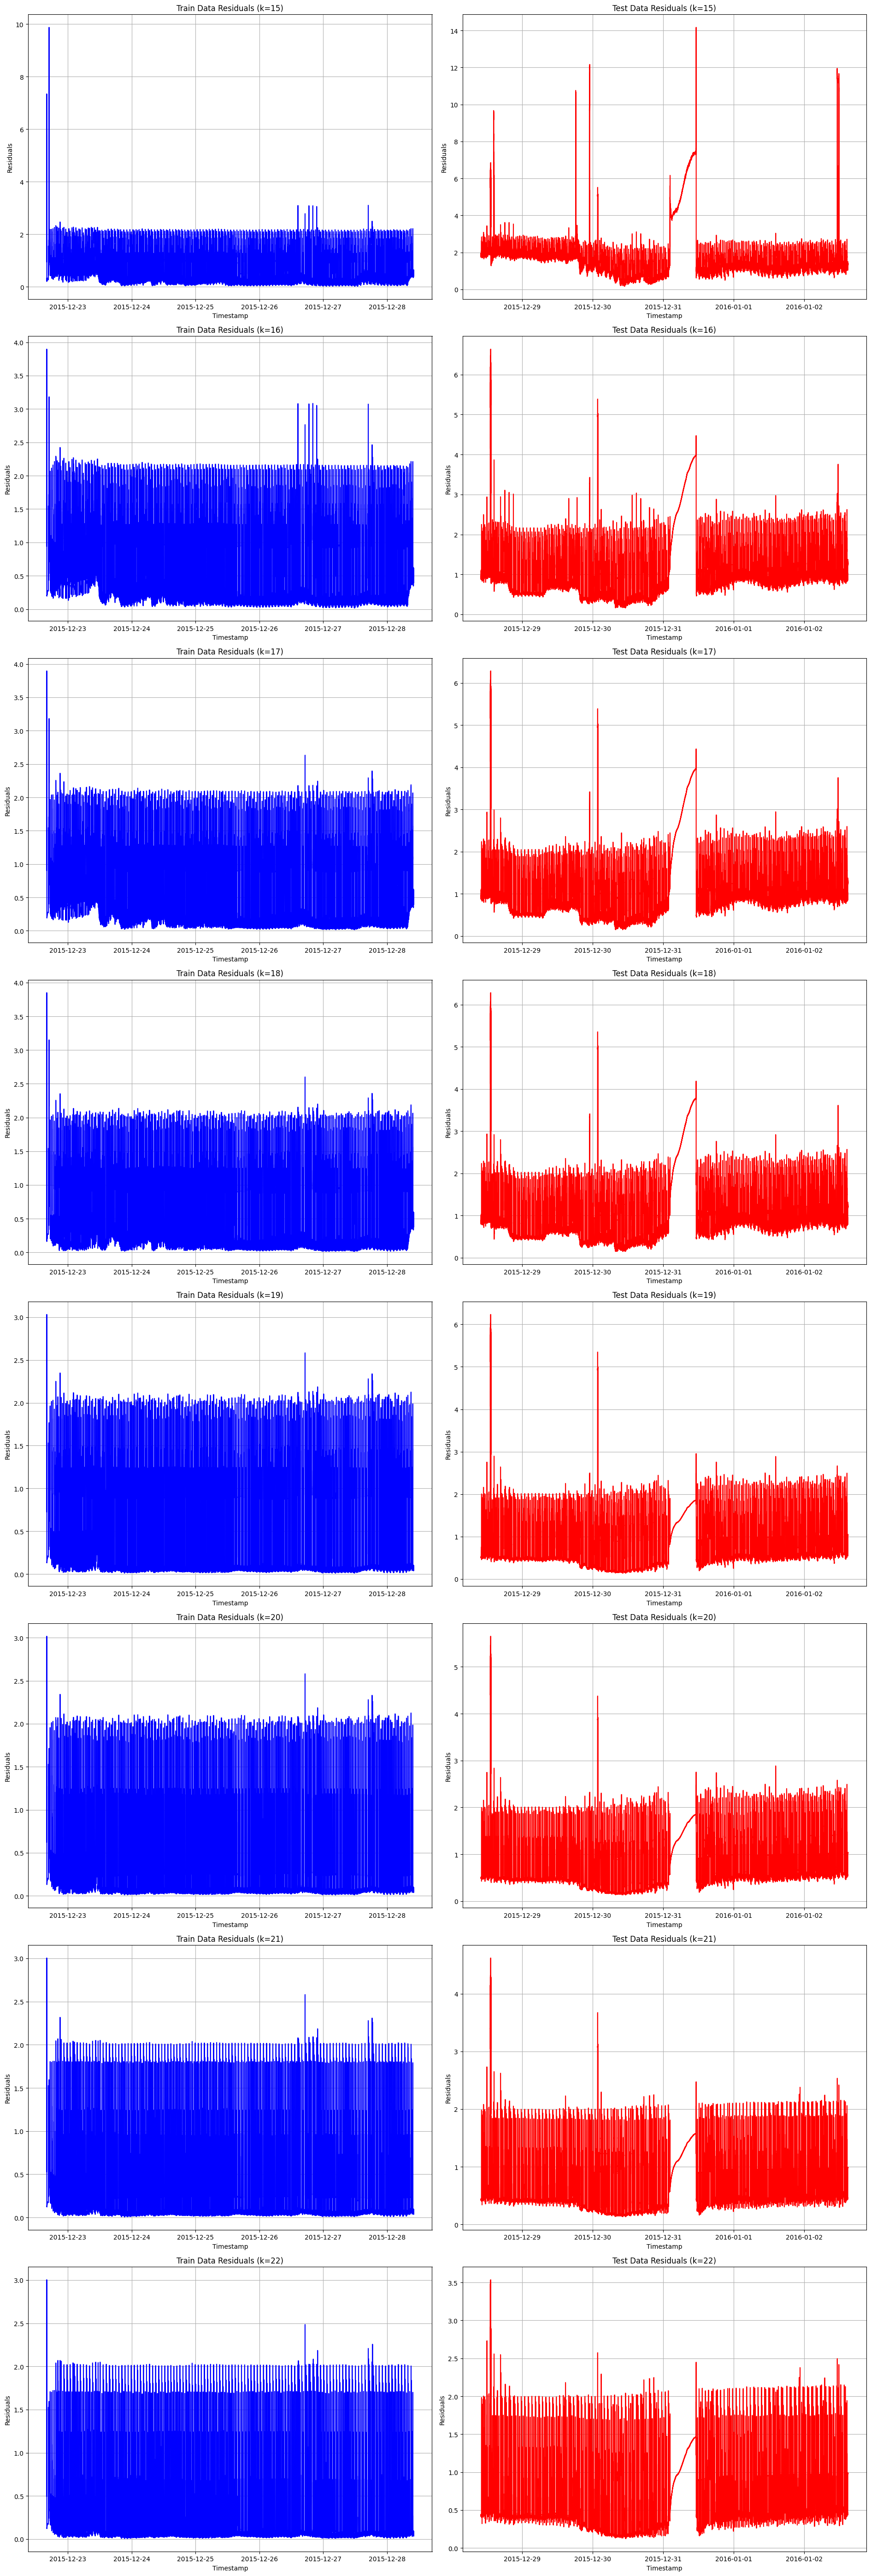

In [26]:

def run_pca_and_visualize(train_data, test_data, k_range):
    n_cols = 2
    n_rows = len(k_range)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(19, n_rows * 7))

    for i, k in enumerate(k_range):
        # Compute PCA
        eigenvectors = principal_component_analysis(train_data, k)

        # Apply PCA and calculate residuals for training data
        transformed_train_data = apply_principal_component_analysis(train_data, eigenvectors)
        original_mean_train = train_data.mean(axis=0).values
        residuals_train = calculate_residuals(train_data.values, transformed_train_data, eigenvectors, original_mean_train)

        # Apply PCA and calculate residuals for test data
        transformed_test_data = apply_principal_component_analysis(test_data, eigenvectors)
        original_mean_test = test_data.mean(axis=0).values
        residuals_test = calculate_residuals(test_data.values, transformed_test_data, eigenvectors, original_mean_test)

        # Plot residuals for training data
        axs[i, 0].plot(train_data_original['Timestamp'][0:len(residuals_train)], residuals_train, color='blue')
        axs[i, 0].set_title(f'Train Data Residuals (k={k})')
        axs[i, 0].set_xlabel('Timestamp')
        axs[i, 0].set_ylabel('Residuals')
        axs[i, 0].grid(True)

        # Plot residuals for test data
        axs[i, 1].plot(test_data_original['Timestamp'][0:len(residuals_test)], residuals_test, color='red')
        axs[i, 1].set_title(f'Test Data Residuals (k={k})')
        axs[i, 1].set_xlabel('Timestamp')
        axs[i, 1].set_ylabel('Residuals')
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
k_values = range(15, 23)
run_pca_and_visualize(normalized_train_data, normalized_test_data, k_values)